# Face Detection Evaluation and Experimentation Notebook
Notebook used for experiments and evaluations on the face detection algorithm used in this project.  
Currently finds the accuracy and IoU values for every face and frame

In [1]:
import cv2, torch, os, glob
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from dataLoader import Train_Loader, Test_Loader, extract_labels
from utils import tools, misc
from faceDetection.faceDetector import FaceDetection
from evaluation import face_evaluate, general_face_evaluation

### Intersection over Union
Code to calculate Intersection over Union values for the faces detected.  
Somewhat misleading since we have to resize the frames for face detection to work and bounding boxes for the faces in the annotations/labels are for the original frame before resizing.  
We aren't expecting good results

In [2]:
def get_IoU(prediction, actual, h, w):
    '''
    Function used to get IoU values for faces detected

    Params:
        prediction: faces detected using our algorithm
        actual: annotation/label for the frame from the csv file

    Return: Array of IoU values for each face detected
    '''
    
    ious = []
    # Get face bound boxes for the labels
    if torch.is_tensor(actual[1]):
        a_faces = actual[1].numpy()
    else:
        a_faces = actual[1]

    # If no label is returned for the frame 
    if len(prediction) == 0:
        return None

    # Evaluates if there is more than one label for the frame
    if len(a_faces.shape) > 1:
        for i in range(len(a_faces)):
            for j in range(len(prediction)):
                # Checks if bounding box for face detected is correct
                # Then compares the predicted label with the actual label and returns the counts
                bound_box = prediction[j][3:7]
                if face_evaluate(bound_box, a_faces[i]):
                    iou = calculate_IoU(bound_box, a_faces[i], h, w)
                    ious.append(iou)

    # Evaluation for frames with single labels   
    else:
        for j in range(len(prediction)):
            bound_box = prediction[j][3:7]
            if face_evaluate(bound_box, a_faces):
                iou = calculate_IoU(bound_box, a_faces, h, w)
                ious.append(iou)

    return ious

In [3]:
def calculate_IoU(predicted, actual, h, w):
    '''
    Function used to calculate the intersection over union (IoU) values for two bounding boxes
    Ammended from: https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

    Params:
        predicted: detected bounding box using our algorithm
        actual: Actual bound box found in the labels/annotation
    
    Return: float IoU value
    '''
    x1, y1, x2, y2 = predicted[:]
    x1 = round(float(x1)*w)
    y1 = round(float(y1)*h)
    x2 = round(float(x2)*w)
    y2 = round(float(y2)*h) 
    
    a_x1, a_y1, a_x2, a_y2 = actual[:]
    a_x1 = round(float(a_x1)*w)
    a_y1 = round(float(a_y1)*h)
    a_x2 = round(float(a_x2)*w)
    a_y2 = round(float(a_y2)*h) 
    
    # Get area of each bounding box
    # +1 used to avoid 0 values
    predicted_area = (x2 - x1) * (y2 - y1)
    actual_area = (a_x2 - a_x1) * (a_y2 - a_y1)

    # Get coordinates for the intersection box
    m_x1 = max(x1, a_x1)
    m_x2 = min(x2, a_x2)

    m_y1 = max(y1, a_y1)
    m_y2 = min(y2, a_y2)

    # Calculate intersection and union areas to get IoU
    inter = max(0, (m_x2 - m_x1 + 1)) * max(0, (m_y2 - m_y1 + 1))
    union = float(predicted_area + actual_area - inter)
    
    if union == 0:
        return 0

    iou = inter / union
    return iou

### Examples and Figures 

In [4]:
def predicition_ex():
    # frame = cv2.imread('dataset/test/2qQs3Y9OJX0/2qQs3Y9OJX0_929.0.jpg')
    # frame = cv2.imread('dataset/test/4ZpjKfu6Cl8/4ZpjKfu6Cl8_954.75.jpg')
    # frame = cv2.imread('dataset/test/HV0H6oc4Kvs/HV0H6oc4Kvs_963.79.jpg')
    # frame = cv2.imread('dataset/train/Db19rWN5BGo/Db19rWN5BGo_911.0.jpg')
    frame = cv2.imread('dataset/trial/BCiuXAuCKAU_1093.59.jpg')
    # frame = cv2.imread('dataset/test/2qQs3Y9OJX0/2qQs3Y9OJX0_929.0.jpg')

    
    frame = cv2.GaussianBlur(frame, (5,5), 2.5)
    img_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    img_hsv[:,:,2] = cv2.equalizeHist(img_hsv[:,:,2])
    frame = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)
    frame = cv2.resize(frame, (300,300))

    face_detect = FaceDetection(frame, 0.2)
    faces = face_detect.detect()

    tools.plot_faces_detected(frame, faces)

predicition_ex()

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\smooth.dispatch.cpp:617: error: (-215:Assertion failed) !_src.empty() in function 'cv::GaussianBlur'


In [ ]:
def IoU_ex():
    frame = cv2.imread('dataset/test/4ZpjKfu6Cl8/4ZpjKfu6Cl8_921.92.jpg')
    frame = cv2.GaussianBlur(frame, (5,5), 2.5)
    img_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    img_hsv[:,:,2] = cv2.equalizeHist(img_hsv[:,:,2])
    frame = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)
    frame = cv2.resize(frame, (300,300))

    face_detect = FaceDetection(frame, 0.2)
    faces = face_detect.detect()

    label = [0.291289, 0.0193548, 0.497278, 0.445161]

    h, w = frame.shape[:2]

    for face in faces:
        x1, y1, x2, y2 = face[3:7] 
        x1 = round(float(x1)*w)
        y1 = round(float(y1)*h)
        x2 = round(float(x2)*w)
        y2 = round(float(y2)*h) 
        
        # Draw a rectangle around the face
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 4)

    a_x1, a_y1, a_x2, a_y2 = label[:]
    a_x1 = round(float(a_x1)*w)
    a_y1 = round(float(a_y1)*h)
    a_x2 = round(float(a_x2)*w)
    a_y2 = round(float(a_y2)*h) 
    cv2.rectangle(frame, (a_x1, a_y1), (a_x2, a_y2), (0, 255, 0), 4)
    frame = cv2.resize(frame, (400,400))

    print(calculate_IoU(faces[0][3:7], label, h, w))
    cv2.imshow('frame', frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

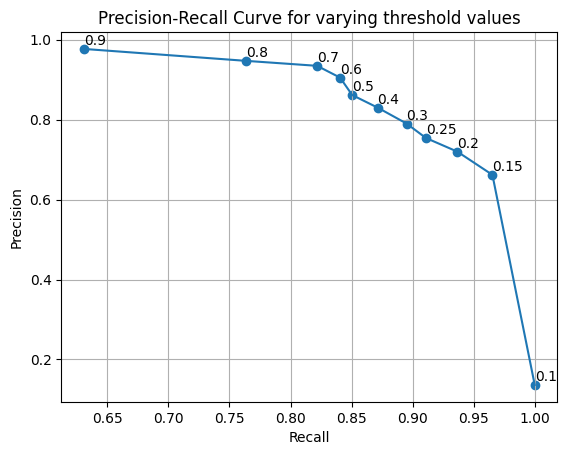

In [17]:
def precision_recall():
    threshs = [0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    # precision = [0.13630, 0.661914,  0.719939, 0.754098, 0.79020, 0.93991, 0.97663, 0.98956, 0.994535, 0.99804, 1]
    # recall = [1, 0.84554, 0.965346, 0.910891, 0.8950495, 0.69794, 0.66934, 0.65103, 0.62471, 0.582379, 0.48283]
    precision = [0.13630, 0.661914, 0.719939, 0.754098, 0.7902097, 0.8301886, 0.8615847, 
    0.9051172, 0.9346846, 0.947174, 0.9769938]

    recall = [1, 0.965346, 0.936633, 0.910891, 0.8950495, 0.8712871, 0.850495, 
    0.8405940, 0.82178, 0.763366, 0.630693]

    # 0.13 0.52215 0.87643

    plt.plot(recall, precision)
    plt.scatter(recall, precision)
    
    for i, txt in enumerate(threshs):
        plt.annotate(txt, (recall[i], precision[i]+0.01), fontsize=10)

    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.title('Precision-Recall Curve for varying threshold values')
    plt.grid()
    plt.show()

precision_recall()    

### Evaluation Code
Code to run the evaluations  
Some functions used can be found in the evaluation.py file   
Can change videos used by editing the first two lines of the file  
Can also change the threshold value for the face detection algorithm which is the probabilty whether a face is detected in the return area  

In [26]:
# ids = ['2qQs3Y9OJX0']
test_ids = ['4ZpjKfu6Cl8', '2qQs3Y9OJX0', 'HV0H6oc4Kvs', 'KHHgQ_Pe4cI', 'BCiuXAuCKAU', 'C25wkwAMB-w']
# test_ids = ['4ZpjKfu6Cl8']

current_path = os.getcwd()
threshold = 0.125
thresholds = [0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

correct = 0
total = 0
faces_detected = 0
ious = []
for video_id in test_ids:
    path = os.path.join(f'{current_path}/dataset/test', video_id) 
    frames = glob.glob(f"{path}/*.jpg")
    frame = cv2.imread(frames[0])
    h,w = frame.shape[:2]

    testLoader = Test_Loader(video_id=video_id, root_dir='test')
    testLoaded = DataLoader(testLoader, batch_size=64, num_workers=0, shuffle=False)

    for images, labels in testLoaded:
        for i in range(len(images)):
            actual_label = extract_labels(testLoader.labels, labels, i)
            # Apply Face Detection Algorithm
            face_detect = FaceDetection(images[i].numpy(), threshold)
            faces = face_detect.detect()

            # Get evaluation values -uses function from evaluation file
            vid_correct, vid_total = general_face_evaluation(faces, actual_label)
            ious.append(get_IoU(faces, actual_label, h, w))
                        
            correct += vid_correct
            total += vid_total
            faces_detected += len(faces)


accuracy = correct / total
# Converts md array to 1d
ious = [i for i in ious if i is not None]
ious = np.array(sum(ious, []))

print(f'\n------ Total Face Evaluation ------')
print(f'Correct: {correct}')
print(f'Total Number of Faces in labels: {total}')
print(f'Total Number of Faces Detected:  {faces_detected}')
print(f'\nAccuracy: {accuracy}')

precision = correct / (correct + (faces_detected - correct))
recall = correct / (correct + (total - correct))
f_score = (2 * precision * recall) / (precision + recall)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f_score}')

print(f'\n------------IoU----------------')     
print(f'Mean: {np.mean(ious)}')
print(f'Median: {np.median(ious)}')       
print(f'Max: {max(ious)}')
print(f'Min: {min(ious)}')


------ Total Face Evaluation ------
Correct: 985
Total Number of Faces in labels: 1010
Total Number of Faces Detected:  2463

Accuracy: 0.9752475247524752
Precision: 0.3999187982135607
Recall: 0.9752475247524752
F1: 0.56723293982148

------------IoU----------------
Mean: 0.3993802288128043
Median: 0.4592763267886689
Max: 0.9023164945576333
Min: 0.003060847538128661
